In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from keras.models import Sequential, clone_model, Model
from keras.layers import concatenate, Dense, Activation, Conv2D, Input, MaxPooling2D, Flatten, Reshape, Dropout, UpSampling2D, Conv2DTranspose
from keras import optimizers
from keras import utils
from keras.utils import np_utils
from keras.activations import relu
import random
from tqdm import tqdm

Using TensorFlow backend.


# Generator code

In [2]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in tqdm(range(nb_samples)):
        # if i % 10 == 0:
        #     print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in tqdm(range(nb_samples)):
        # if i % 10 == 0:
        #     print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

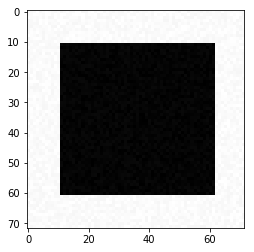

In [3]:
im = generate_a_rectangle(10, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

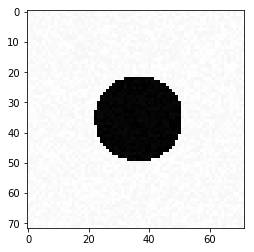

In [4]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

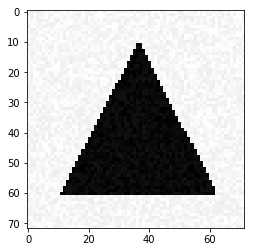

In [5]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

# A usefull plot function

In [6]:
def plot_history(history):
    if 'acc' in  history.history.keys():
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
        ax1.plot(history.history['acc'])
        ax1.plot(history.history['val_acc'])
        ax1.set_title('model accuracy')
        ax1.set_ylabel('accuracy')
        ax1.set_xlabel('epoch')
        ax1.legend(['train', 'test'], loc='upper left')
        ax2.plot(history.history['loss'])
        ax2.plot(history.history['val_loss'])
        ax2.set_title('model loss')
        ax2.set_ylabel('loss')
        ax2.set_xlabel('epoch')
        ax2.legend(['train', 'test'], loc='upper left')
    else:
        fig, ax2 = plt.subplots(1, 1, figsize=(20, 7))
        ax2.plot(history.history['loss'])
        ax2.plot(history.history['val_loss'])
        ax2.set_title('model loss')
        ax2.set_ylabel('loss')
        ax2.set_xlabel('epoch')
        ax2.legend(['train', 'test'], loc='upper left')

# 3. Simple Classification

## 3.1 Generating datasets
-0: rectangle
-1: disk
-2: triangle

In [7]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
print(X_train)

Creating data:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 82.42it/s]


[[0.95700851 0.97219956 0.93928197 ... 0.96111005 0.9533014  0.96128967]
 [0.94601064 0.98905457 0.98756218 ... 0.95785107 0.97297352 0.9850174 ]
 [0.95471397 0.97333741 0.96445391 ... 0.9560653  0.95201672 0.99135859]
 ...
 [0.9566403  0.96476131 0.98315962 ... 0.93901617 0.95495466 0.95891562]
 [0.96876527 0.95662675 0.94693692 ... 0.98681609 0.96938229 0.98962424]
 [0.99265032 0.98051334 0.9423929  ... 0.98856499 0.9613846  0.99456682]]


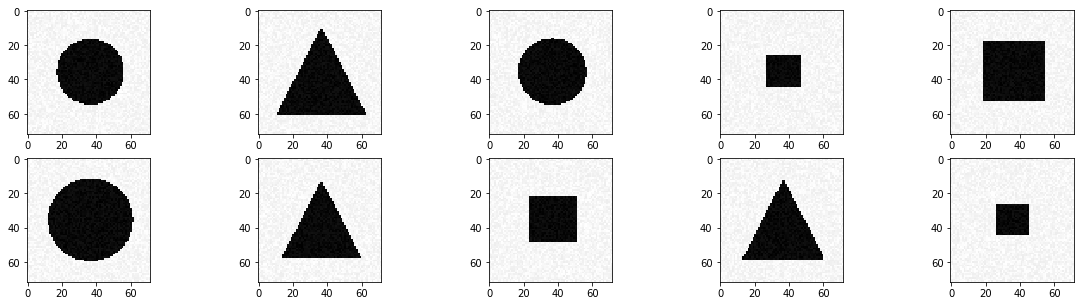

In [8]:
select = 10
fig, ax = plt.subplots(2, 5, figsize=(20, 5))
batch = random.choices(X_train, k=select)
for i in range(select):
    ax[i // 5, i % 5].imshow(batch[i].reshape(IMAGE_SIZE, -1), cmap='gray')

## 3.2 Models
### 3.2.1 Base model and optimizers

In [9]:
model = Sequential()
model.add(Dense(3, input_shape=(IMAGE_SIZE**2,), activation='softmax'))
sgd = optimizers.SGD(lr=0.001)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.95, epsilon=None, decay=0.0, amsgrad=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 15555     
Total params: 15,555
Trainable params: 15,555
Non-trainable params: 0
_________________________________________________________________


### 3.2.2 SGD Training

In [10]:
sgd_model = clone_model(model)
sgd_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
history = sgd_model.fit(X_train, utils.to_categorical(Y_train, 3), batch_size=32, epochs=200, verbose=0, validation_split=0.2)

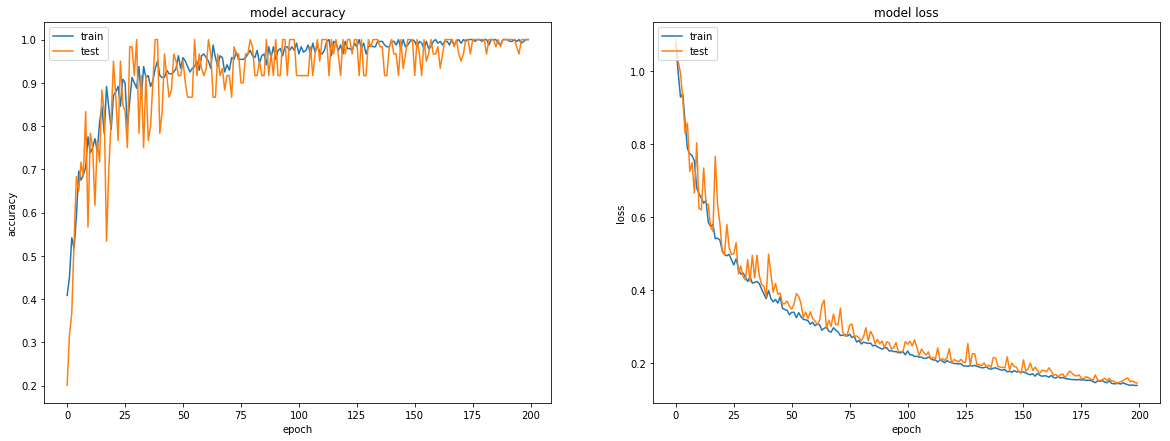

In [11]:
plot_history(history)

### 3.2.3 Adam Training

In [12]:
adam_model = clone_model(model)
adam_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history = adam_model.fit(X_train, utils.to_categorical(Y_train, 3), batch_size=32, epochs=50, verbose=0, validation_split=0.2)

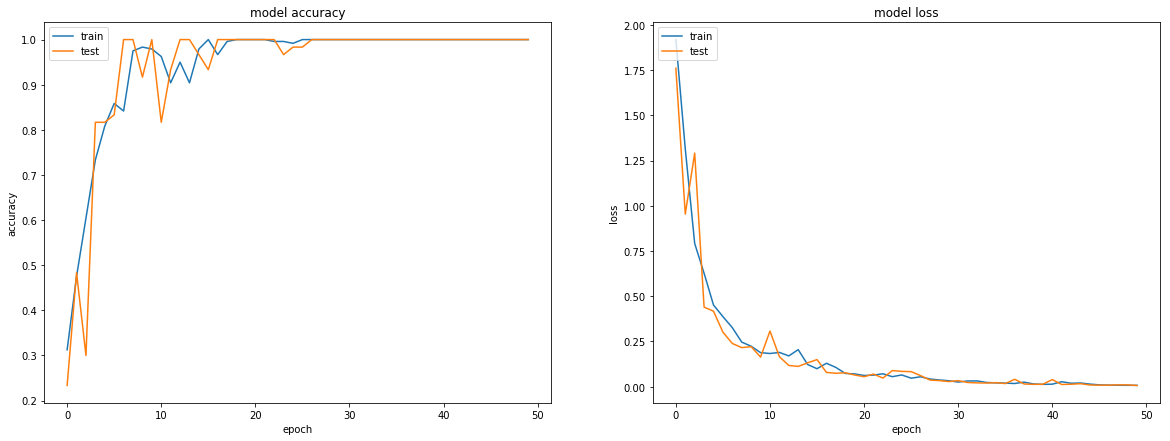

In [13]:
plot_history(history)

Adam optimizers converges way faster than SGD for this problem. About 25 epochs are enough to reach the same accuracy and loss as the SGD in 200 epochs.

Anyways, both solutions work very well in a reasonnable amount of time

## 3.3 Validation

In [14]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
adam_model.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

In [15]:
X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0])
adam_model.predict(X_test)

array([[1., 0., 0.]], dtype=float32)

In [16]:
X_test = generate_a_triangle()[0]
X_test = X_test.reshape(1, X_test.shape[0])
adam_model.predict(X_test)

array([[0., 0., 1.]], dtype=float32)

The model gets the correct answer for each test

# 4. Visualization of the Solution

In [17]:
weights = adam_model.get_weights()[0]
np.shape(weights)

(5184, 3)

## 4.1 First column

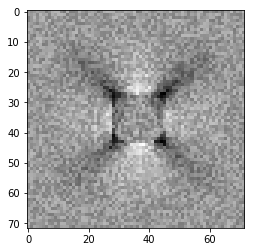

In [18]:
plt.imshow(weights[:, 0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

# 4.2 Second column

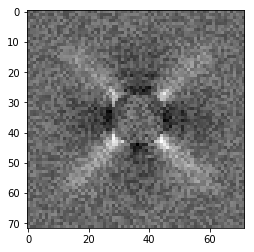

In [19]:
plt.imshow(weights[:, 1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

# 4.3 Third column

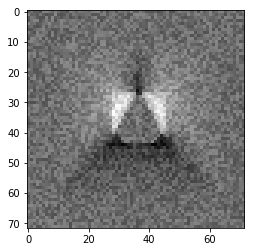

In [20]:
plt.imshow(weights[:, 2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

# 5. A More Difficult Classification Problem

## 5.1 Generating datasets

In [21]:
[X_train, Y_train] = generate_dataset_classification(1000, 20, True)
[X_test, Y_test] = generate_test_set_classification()

Creating data:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 80.41it/s]


Creating data:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.38it/s]


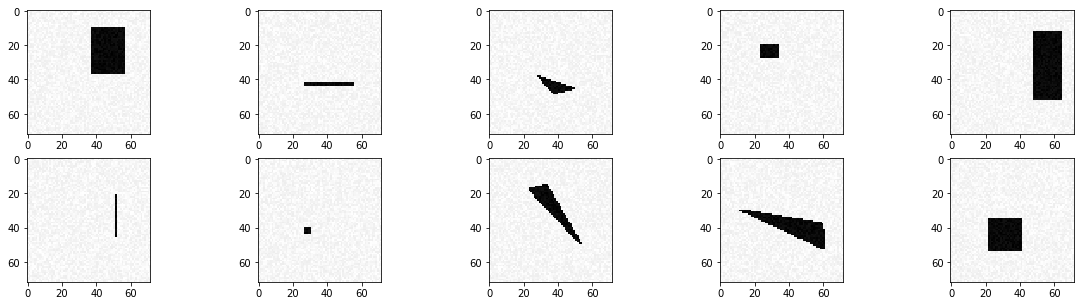

In [22]:
select = 10
fig, ax = plt.subplots(2, 5, figsize=(20, 5))
batch = random.choices(X_train, k=select)
for i in range(select):
    ax[i // 5, i % 5].imshow(batch[i].reshape(IMAGE_SIZE, -1), cmap='gray')

This new problem is way more complicated as the shapes are more random.

## 5.2 Testing our linear classifier

In [23]:
adam_model = clone_model(model)
adam_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history = adam_model.fit(X_train, utils.to_categorical(Y_train, 3), batch_size=32, epochs=200, verbose=0, validation_split=0.2)

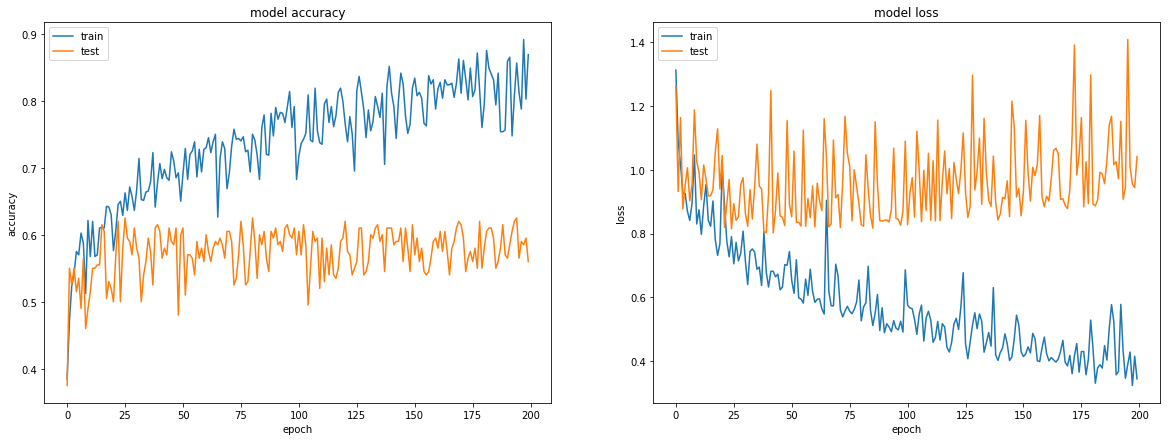

In [24]:
plot_history(history)

In [25]:
adam_model.evaluate(X_test, Y_test)

300/300 [==============================] - ETA:  - 0s 144us/step


[0.9894873444239298, 0.56]

Our linear classifier is not very good for this problem, with low test accuracy (and high losses).
We experience some overfitting after 40 epochs.

## 5.3 A deep convolutional model

In [26]:
c_model = Sequential()
c_model.add(Reshape(target_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), input_shape=(IMAGE_SIZE**2,)))
c_model.add(Conv2D(16, (5, 5), activation="relu"))
c_model.add(MaxPooling2D(pool_size=(2, 2)))
c_model.add(Flatten())
c_model.add(Dense(3, activation='softmax'))
c_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 72, 72, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 68, 68, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 55491     
Total params: 55,907
Trainable params: 55,907
Non-trainable params: 0
_________________________________________________________________


In [27]:
c_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history = c_model.fit(X_train, utils.to_categorical(Y_train, 3), batch_size=32, epochs=100, verbose=1, validation_split=0.2)

Train on 800 samples, validate on 200 samples
Epoch 1/100
800/800 [==============================] - ETA: 27s - loss: 1.1579 - acc: 0.25 - ETA: 2s - loss: 1.1049 - acc: 0.3785 - ETA: 0s - loss: 1.0456 - acc: 0.463 - 1s 2ms/step - loss: 0.9974 - acc: 0.5050 - val_loss: 0.8361 - val_acc: 0.7100
Epoch 2/100
800/800 [==============================] - ETA: 0s - loss: 0.7875 - acc: 0.875 - ETA: 0s - loss: 0.7553 - acc: 0.760 - ETA: 0s - loss: 0.7290 - acc: 0.742 - 0s 231us/step - loss: 0.7490 - acc: 0.7000 - val_loss: 0.8100 - val_acc: 0.6050
Epoch 3/100
800/800 [==============================] - ETA: 0s - loss: 0.5035 - acc: 0.750 - ETA: 0s - loss: 0.6273 - acc: 0.760 - ETA: 0s - loss: 0.6145 - acc: 0.775 - 0s 239us/step - loss: 0.6329 - acc: 0.7625 - val_loss: 0.6955 - val_acc: 0.7000
Epoch 4/100
800/800 [==============================] - ETA: 0s - loss: 0.5729 - acc: 0.750 - ETA: 0s - loss: 0.5791 - acc: 0.770 - ETA: 0s - loss: 0.5770 - acc: 0.788 - 0s 233us/step - loss: 0.5658 - acc: 0.7

Epoch 33/100
800/800 [==============================] - ETA: 0s - loss: 0.0119 - acc: 1.000 - ETA: 0s - loss: 0.0219 - acc: 1.000 - ETA: 0s - loss: 0.0226 - acc: 1.000 - 0s 228us/step - loss: 0.0230 - acc: 1.0000 - val_loss: 0.6726 - val_acc: 0.8100
Epoch 34/100
800/800 [==============================] - ETA: 0s - loss: 0.0191 - acc: 1.000 - ETA: 0s - loss: 0.0207 - acc: 1.000 - ETA: 0s - loss: 0.0213 - acc: 1.000 - 0s 226us/step - loss: 0.0216 - acc: 1.0000 - val_loss: 0.7048 - val_acc: 0.7900
Epoch 35/100
800/800 [==============================] - ETA: 0s - loss: 0.0220 - acc: 1.000 - ETA: 0s - loss: 0.0173 - acc: 1.000 - ETA: 0s - loss: 0.0183 - acc: 1.000 - 0s 226us/step - loss: 0.0181 - acc: 1.0000 - val_loss: 0.6863 - val_acc: 0.7900
Epoch 36/100
800/800 [==============================] - ETA: 0s - loss: 0.0138 - acc: 1.000 - ETA: 0s - loss: 0.0136 - acc: 1.000 - ETA: 0s - loss: 0.0148 - acc: 1.000 - 0s 224us/step - loss: 0.0140 - acc: 1.0000 - val_loss: 0.7267 - val_acc: 0.7900


800/800 [==============================] - ETA: 0s - loss: 1.7703e-04 - acc: 1.000 - ETA: 0s - loss: 1.7037e-04 - acc: 1.000 - ETA: 0s - loss: 1.5434e-04 - acc: 1.000 - 0s 232us/step - loss: 1.5892e-04 - acc: 1.0000 - val_loss: 1.1061 - val_acc: 0.8000
Epoch 66/100
800/800 [==============================] - ETA: 0s - loss: 1.0794e-04 - acc: 1.000 - ETA: 0s - loss: 1.2917e-04 - acc: 1.000 - ETA: 0s - loss: 1.1442e-04 - acc: 1.000 - 0s 229us/step - loss: 1.1664e-04 - acc: 1.0000 - val_loss: 1.1373 - val_acc: 0.8050
Epoch 67/100
800/800 [==============================] - ETA: 0s - loss: 9.5865e-05 - acc: 1.000 - ETA: 0s - loss: 9.6987e-05 - acc: 1.000 - ETA: 0s - loss: 1.0844e-04 - acc: 1.000 - 0s 228us/step - loss: 9.8032e-05 - acc: 1.0000 - val_loss: 1.1125 - val_acc: 0.8050
Epoch 68/100
800/800 [==============================] - ETA: 0s - loss: 1.2358e-04 - acc: 1.000 - ETA: 0s - loss: 8.0632e-05 - acc: 1.000 - ETA: 0s - loss: 8.2738e-05 - acc: 1.000 - 0s 234us/step - loss: 7.5748e-05 

800/800 [==============================] - ETA: 0s - loss: 1.1157e-06 - acc: 1.000 - ETA: 0s - loss: 1.1869e-06 - acc: 1.000 - ETA: 0s - loss: 9.9630e-07 - acc: 1.000 - 0s 225us/step - loss: 9.5234e-07 - acc: 1.0000 - val_loss: 1.4433 - val_acc: 0.8000
Epoch 96/100
800/800 [==============================] - ETA: 0s - loss: 5.5134e-07 - acc: 1.000 - ETA: 0s - loss: 6.5627e-07 - acc: 1.000 - ETA: 0s - loss: 7.8374e-07 - acc: 1.000 - 0s 223us/step - loss: 7.4908e-07 - acc: 1.0000 - val_loss: 1.4573 - val_acc: 0.8000
Epoch 97/100
800/800 [==============================] - ETA: 0s - loss: 5.2154e-07 - acc: 1.000 - ETA: 0s - loss: 5.0366e-07 - acc: 1.000 - ETA: 0s - loss: 5.6573e-07 - acc: 1.000 - 0s 222us/step - loss: 5.6267e-07 - acc: 1.0000 - val_loss: 1.4388 - val_acc: 0.8050
Epoch 98/100
800/800 [==============================] - ETA: 0s - loss: 1.6764e-06 - acc: 1.000 - ETA: 0s - loss: 9.1065e-07 - acc: 1.000 - ETA: 0s - loss: 8.5961e-07 - acc: 1.000 - 0s 223us/step - loss: 8.0005e-07 

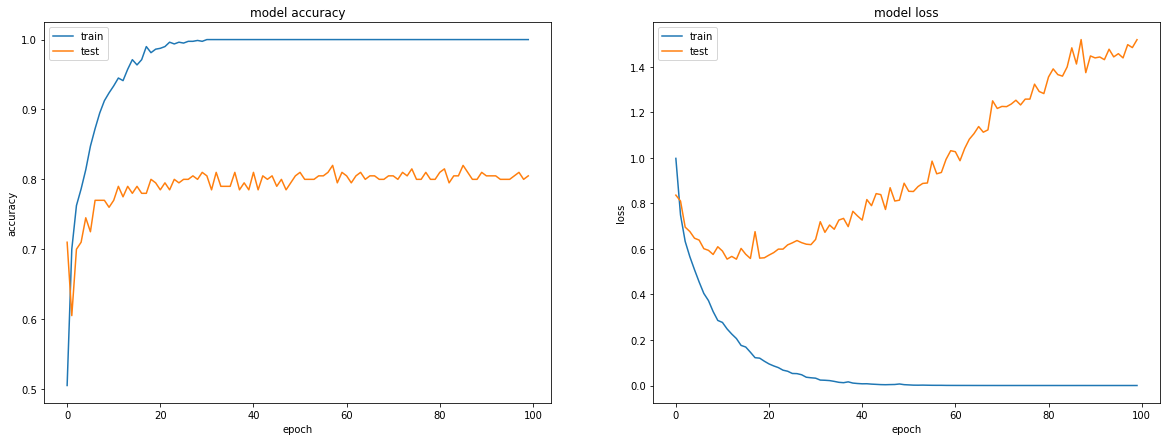

In [28]:
plot_history(history)

In [29]:
c_model.evaluate(X_test, Y_test)

300/300 [==============================] - ETA:  - 0s 132us/step


[1.5684249846140543, 0.7799999992052714]

The model is overfitting after 20 epochs, but convergence rate is faster and accuracy is better 80% vs. 57%

# 6. A Regression Problem
## 6.1 Generating datasets

In [30]:
[X_train, Y_train] = generate_dataset_regression(1000, 20)
[X_test, Y_test] = generate_test_set_regression()

Creating data:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 79.77it/s]


Creating data:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 81.41it/s]


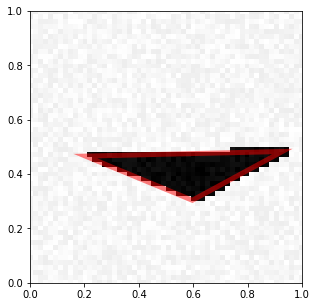

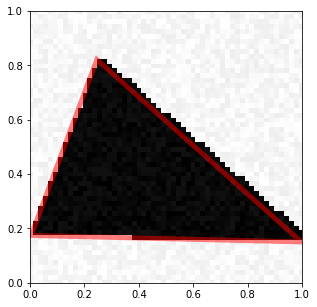

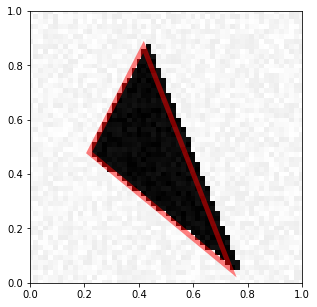

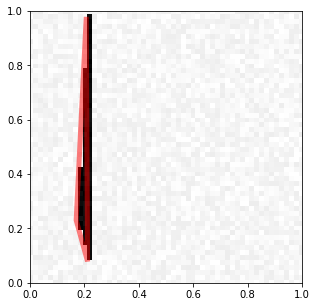

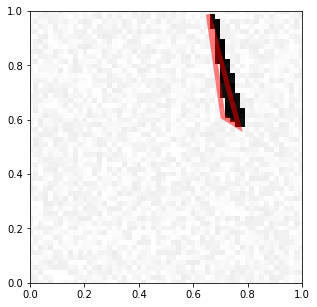

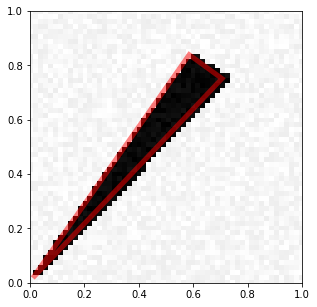

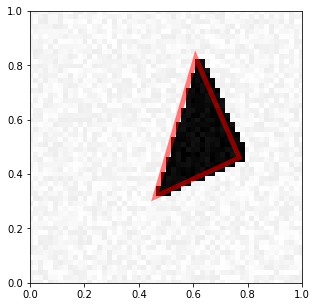

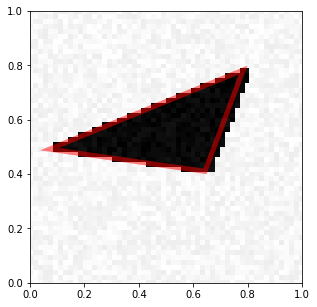

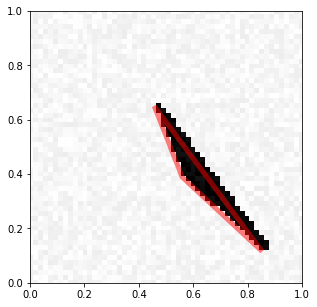

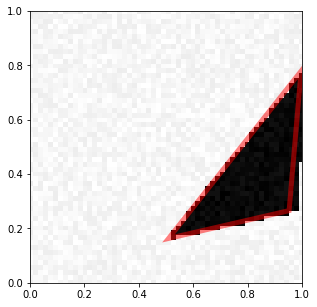

In [31]:
select = 10
rand = np.random.choice(len(X_train), size=select)
for i in rand:
    visualize_prediction(X_train[i], Y_train[i])

We need to reorder the vertices of the triangle. Indeed a single triangle as several representations which will make it impossible for the algorithm to converge. We choose a unique representation for each triangle.
## 6.2 Preprocessing

In [32]:
def reorder_ys(Y_train):
    y_b = Y_train.copy()
    temp = y_b.reshape((Y_train.shape[0],3,2))
    res = []
    for y in temp:
        res.append(y[y[:,0].argsort()])
    return temp.reshape(Y_train.shape[0], 6)

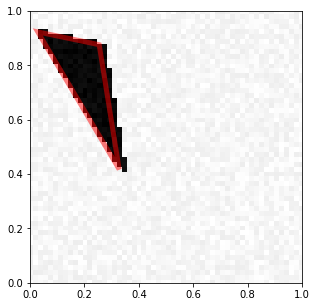

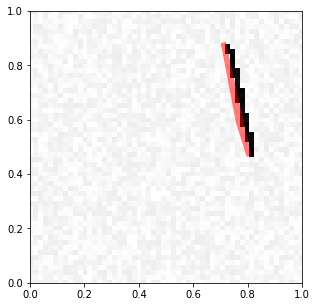

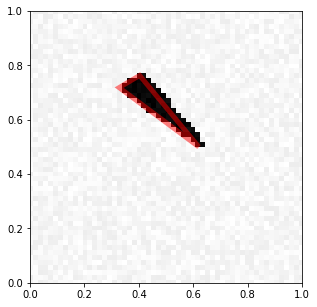

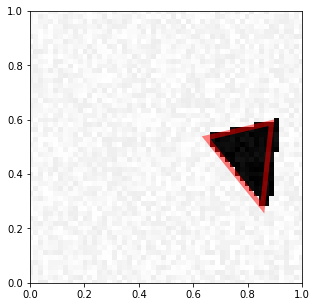

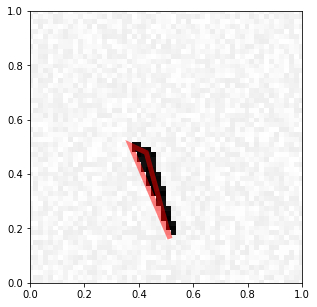

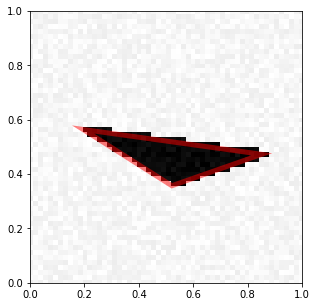

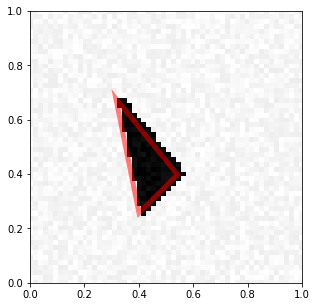

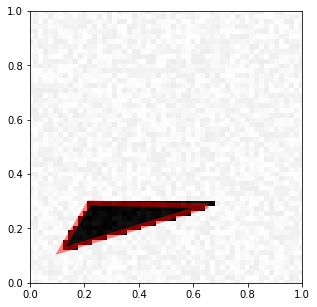

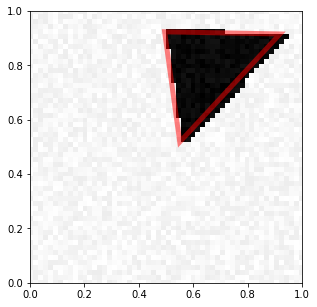

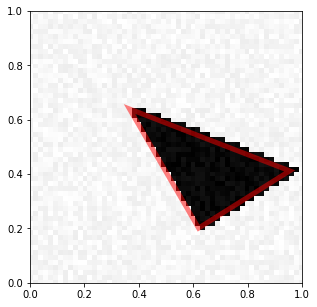

In [33]:
select = 10
rand = np.random.choice(len(X_train), size=select)
for i in rand:
    visualize_prediction(X_train[i], reorder_ys(Y_train)[i])

## 6.3 Model

In [34]:
r_model = Sequential()
r_model.add(Reshape(target_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), input_shape=(IMAGE_SIZE**2,)))
r_model.add(Conv2D(16, (5, 5), activation='relu'))
# r_model.add(Conv2D(16, (3, 3), activation='relu'))
r_model.add(Conv2D(16, (3, 3), activation='relu'))
# r_model.add(MaxPooling2D(pool_size=(5, 5)))
r_model.add(Flatten())
r_model.add(Dense(64, activation='relu'))
r_model.add(Dropout(0.25))
r_model.add(Dense(6, activation="sigmoid"))
r_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 72, 72, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 68, 68, 16)        416       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 66, 66, 16)        2320      
_________________________________________________________________
flatten_2 (Flatten)          (None, 69696)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4460608   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
Total para

In [35]:
adam_2 = optimizers.Adam(lr=0.001)
r_model.compile(optimizer=adam_2, loss='mean_squared_error')
history = r_model.fit(X_train, reorder_ys(Y_train), batch_size=32, epochs=20, verbose=1, validation_split=0.3)

Train on 700 samples, validate on 300 samples
Epoch 1/20
700/700 [==============================] - ETA: 17s - loss: 0.08 - ETA: 2s - loss: 0.2052 - ETA: 1s - loss: 0.190 - ETA: 0s - loss: 0.157 - ETA: 0s - loss: 0.141 - ETA: 0s - loss: 0.130 - 1s 2ms/step - loss: 0.1291 - val_loss: 0.0804
Epoch 2/20
700/700 [==============================] - ETA: 0s - loss: 0.078 - ETA: 0s - loss: 0.087 - ETA: 0s - loss: 0.086 - ETA: 0s - loss: 0.084 - ETA: 0s - loss: 0.084 - 0s 444us/step - loss: 0.0843 - val_loss: 0.0804
Epoch 3/20
700/700 [==============================] - ETA: 0s - loss: 0.081 - ETA: 0s - loss: 0.083 - ETA: 0s - loss: 0.082 - ETA: 0s - loss: 0.083 - ETA: 0s - loss: 0.082 - 0s 440us/step - loss: 0.0831 - val_loss: 0.0763
Epoch 4/20
700/700 [==============================] - ETA: 0s - loss: 0.081 - ETA: 0s - loss: 0.081 - ETA: 0s - loss: 0.082 - ETA: 0s - loss: 0.081 - ETA: 0s - loss: 0.080 - 0s 476us/step - loss: 0.0805 - val_loss: 0.0739
Epoch 5/20
700/700 [=======================

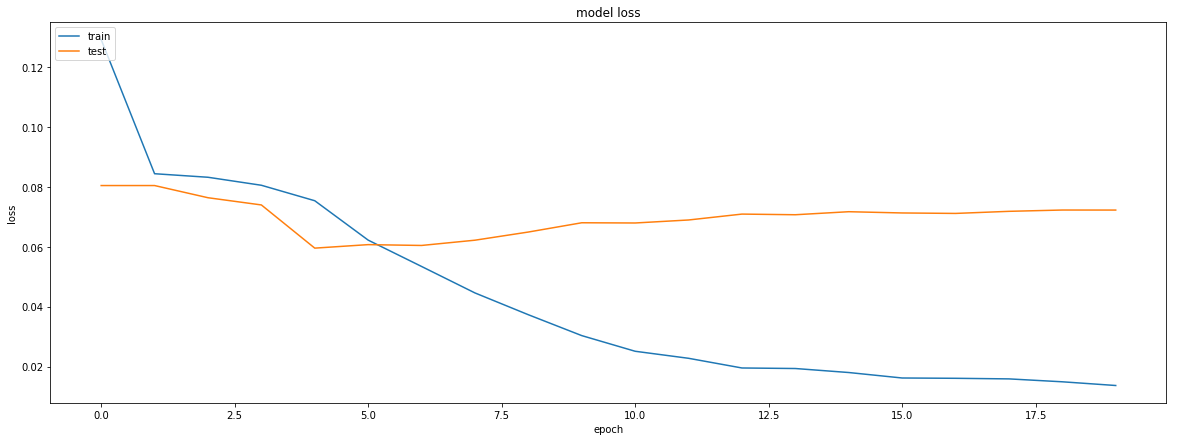

In [36]:
plot_history(history)

### 6.3.1 Overfitting on training set

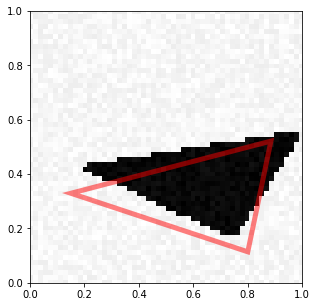

In [37]:
i = random.randint(0, 300)
selected = X_train[i]
visualize_prediction(selected, r_model.predict(selected.reshape(1, selected.shape[0])))

### 6.3.2 And very poor performance on the test set

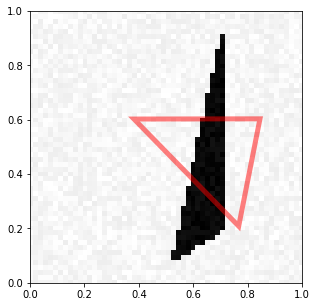

In [38]:
i = random.randint(0, 300)
selected = X_test[i]
visualize_prediction(selected, r_model.predict(selected.reshape(1, selected.shape[0])))

This deep learning model can completely overfit the training data but the result on the test data remains pretty poor. It more or less detects the position of the triangle but cannot find precisely the vertices.

# 7. Image Denoising

## 7.1 New dataset generation functions

In [39]:
def generate_two_drawings(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    noised = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return [noised, imdata]

def generate_a_rectangle_2(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_two_drawings(figsize, U, V, noise)

def generate_a_disk_2(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_two_drawings(figsize, U, V, noise)

def generate_a_triangle_2(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    return generate_two_drawings(figsize, U, V, noise)

def generate_dataset_noise(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle_2()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in tqdm(range(nb_samples)):
        # if i % 10 == 0:
        #     print(i)
        category = np.random.randint(3)
        t_noise = noise * np.random.rand()
        if category == 0:
            [X[i], Y[i]] = generate_a_rectangle_2(t_noise, free_location)
        elif category == 1: 
            [X[i], Y[i]] = generate_a_disk_2(t_noise, free_location)
        else:
            [X[i], Y[i]] = generate_a_triangle_2(t_noise, free_location)
        X[i] = (X[i] + t_noise) / (255 + 2 * t_noise)
    Y = Y / 255
    return [X, Y]

## 7.2 Datasets generation

In [40]:
[X_train, Y_train] = generate_dataset_noise(1000, 80, True)
[X_test, Y_test] = generate_dataset_noise(300, 80, True)

Creating data:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.78it/s]


Creating data:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 80.25it/s]


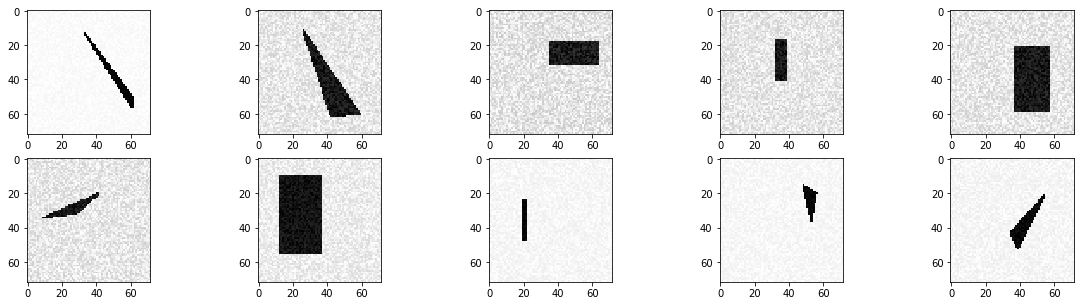

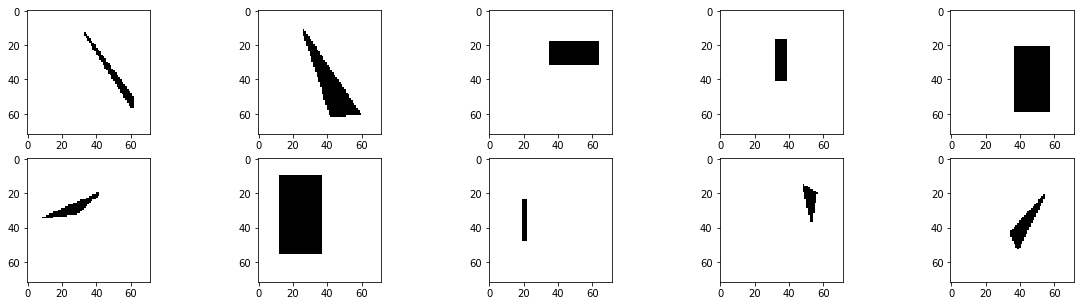

In [41]:
select = 10
fig, ax = plt.subplots(2, 5, figsize=(20, 5))
batch = np.random.choice(len(X_train), select)
for i in range(select):
    ax[i // 5, i % 5].imshow(X_train[batch[i]].reshape(IMAGE_SIZE, -1), cmap='gray')
fig, ax = plt.subplots(2, 5, figsize=(20, 5))
for i in range(select):
    ax[i // 5, i % 5].imshow(Y_train[batch[i]].reshape(IMAGE_SIZE, -1), cmap='gray')

## 7.3 Model

As asked we implement a hourglass model (as simple as possible because the problem is very simple).

In [42]:
IMAGE_SIZE = 72
x_in = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
x_conv1 = Conv2D(16, (5, 5), activation='relu', padding='same')(x_in)
x_conv1 = MaxPooling2D()(x_conv1)

x_conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(x_conv1)
x_conv2 = MaxPooling2D()(x_conv2)

x_up1 = Conv2D(16, (2, 2), activation='relu', padding='same')(x_conv2)
x_up1 = UpSampling2D()(x_up1)
x_up1 = concatenate([x_conv1, x_up1])

x_up2 = Conv2D(16, (2, 2), activation='relu', padding='same')(x_up1)
x_up2= UpSampling2D()(x_up2)
x_up2 = concatenate([x_in, x_up2])

x_out = Conv2D(1, (2,2), activation="sigmoid", padding='same')(x_up2)

d_model = Model(inputs=[x_in], outputs=[x_out])
d_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 72, 72, 1)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 72, 72, 16)   416         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 36, 36, 16)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 36, 36, 16)   2320        max_pooling2d_2[0][0]            
__________________________________________________________________________________________________
max_poolin

In [43]:
d_model.compile(optimizer=adam_2, loss='mean_squared_error')
history = d_model.fit(X_train.reshape(len(X_train), IMAGE_SIZE, IMAGE_SIZE, 1), Y_train.reshape(len(X_train), IMAGE_SIZE, IMAGE_SIZE, 1), batch_size=128, epochs=40, verbose=0, validation_split=0.3)

Convergence is very fast.

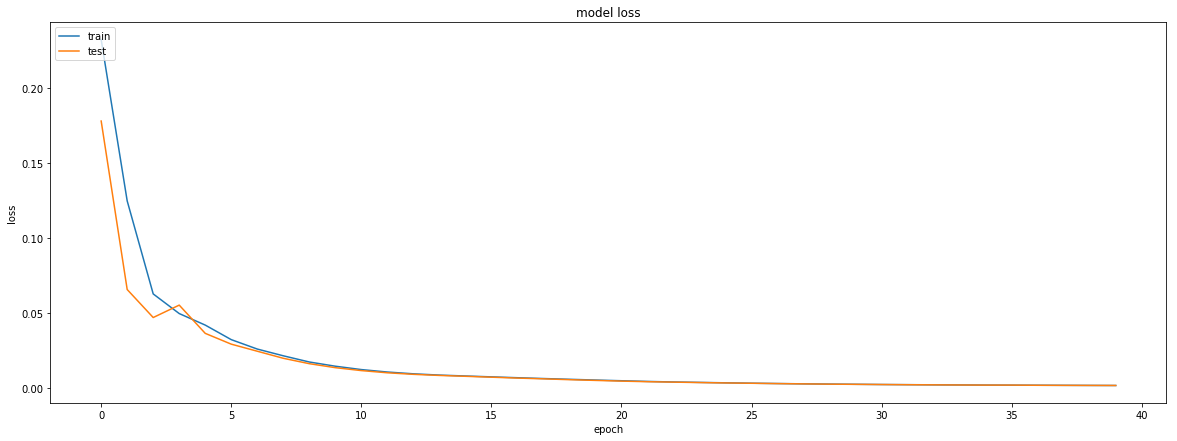

In [44]:
plot_history(history)

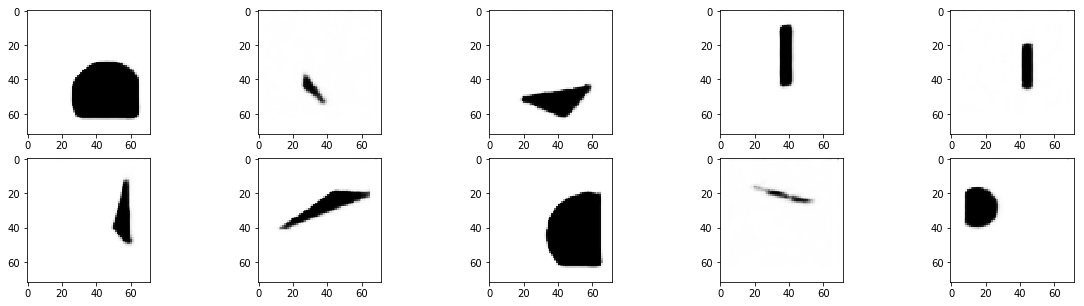

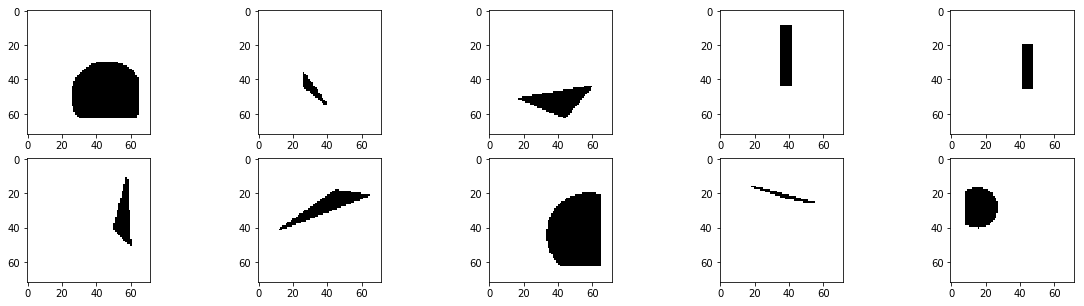

In [45]:
select = 10
fig, ax = plt.subplots(2, 5, figsize=(20, 5))
batch = np.random.choice(len(X_test), select)
for i in range(select):
    selected = X_test[batch[i]]
    selected = selected.reshape(1, selected.shape[0])
    selected = selected.reshape(1,IMAGE_SIZE,IMAGE_SIZE,1)
    ax[i // 5, i % 5].imshow(d_model.predict(selected)[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
fig, ax = plt.subplots(2, 5, figsize=(20, 5))
for i in range(select):
    ax[i // 5, i % 5].imshow(Y_test[batch[i]].reshape(IMAGE_SIZE, -1), cmap='gray')

This model is efficient but overkill. Plus due to the hourglass shape it is blurry.
Let's proove that we can do simpler and better.
## 7.4 Pour le 'fun'

If we were to denoise those images mathematically, we would just have to find a function which values are 0 or 1 with a threshold... which is basically how a neural network works.
This is doable with only a very few number of nodes nodes.

We choose a 5x5 convolution window to be sure that a single black point in space will be understood as noise.

In [46]:
IMAGE_SIZE = 72
lol_model = Sequential()
lol_model.add(Conv2D(1, (5, 5), activation='sigmoid', padding='same', input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
lol_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 72, 72, 1)         26        
Total params: 26
Trainable params: 26
Non-trainable params: 0
_________________________________________________________________


In [47]:
adam_3 = optimizers.Adam(lr=0.1)
lol_model.compile(optimizer=adam_3, loss='mean_squared_error')
history = lol_model.fit(X_train.reshape(len(X_train), IMAGE_SIZE, IMAGE_SIZE, 1), Y_train.reshape(len(Y_train), IMAGE_SIZE, IMAGE_SIZE, 1), batch_size=32, epochs=50, verbose=1, validation_split=0.3)

Train on 700 samples, validate on 300 samples
Epoch 1/50
700/700 [==============================] - ETA: 5s - loss: 0.591 - ETA: 0s - loss: 0.131 - ETA: 0s - loss: 0.109 - 0s 699us/step - loss: 0.1043 - val_loss: 0.0905
Epoch 2/50
700/700 [==============================] - ETA: 0s - loss: 0.092 - ETA: 0s - loss: 0.081 - ETA: 0s - loss: 0.084 - 0s 233us/step - loss: 0.0837 - val_loss: 0.0885
Epoch 3/50
700/700 [==============================] - ETA: 0s - loss: 0.098 - ETA: 0s - loss: 0.081 - ETA: 0s - loss: 0.081 - 0s 233us/step - loss: 0.0801 - val_loss: 0.0808
Epoch 4/50
700/700 [==============================] - ETA: 0s - loss: 0.055 - ETA: 0s - loss: 0.073 - ETA: 0s - loss: 0.070 - 0s 254us/step - loss: 0.0681 - val_loss: 0.0561
Epoch 5/50
700/700 [==============================] - ETA: 0s - loss: 0.042 - ETA: 0s - loss: 0.045 - ETA: 0s - loss: 0.033 - 0s 227us/step - loss: 0.0318 - val_loss: 0.0172
Epoch 6/50
700/700 [==============================] - ETA: 0s - loss: 0.015 - ETA: 0

700/700 [==============================] - ETA: 0s - loss: 3.7159e-0 - ETA: 0s - loss: 4.2765e-0 - ETA: 0s - loss: 4.1174e-0 - 0s 312us/step - loss: 4.1081e-04 - val_loss: 4.3094e-04
Epoch 46/50
700/700 [==============================] - ETA: 0s - loss: 3.9695e-0 - ETA: 0s - loss: 3.9749e-0 - ETA: 0s - loss: 4.1164e-0 - ETA: 0s - loss: 4.0024e-0 - 0s 318us/step - loss: 3.9666e-04 - val_loss: 4.1638e-04
Epoch 47/50
700/700 [==============================] - ETA: 0s - loss: 4.2543e-0 - ETA: 0s - loss: 3.7681e-0 - ETA: 0s - loss: 3.7827e-0 - 0s 264us/step - loss: 3.8318e-04 - val_loss: 4.0328e-04
Epoch 48/50
700/700 [==============================] - ETA: 0s - loss: 4.4433e-0 - ETA: 0s - loss: 3.9290e-0 - ETA: 0s - loss: 3.7416e-0 - 0s 246us/step - loss: 3.7063e-04 - val_loss: 3.9011e-04
Epoch 49/50
700/700 [==============================] - ETA: 0s - loss: 4.2830e-0 - ETA: 0s - loss: 3.6485e-0 - ETA: 0s - loss: 3.5722e-0 - 0s 239us/step - loss: 3.5846e-04 - val_loss: 3.7796e-04
Epoch 50/

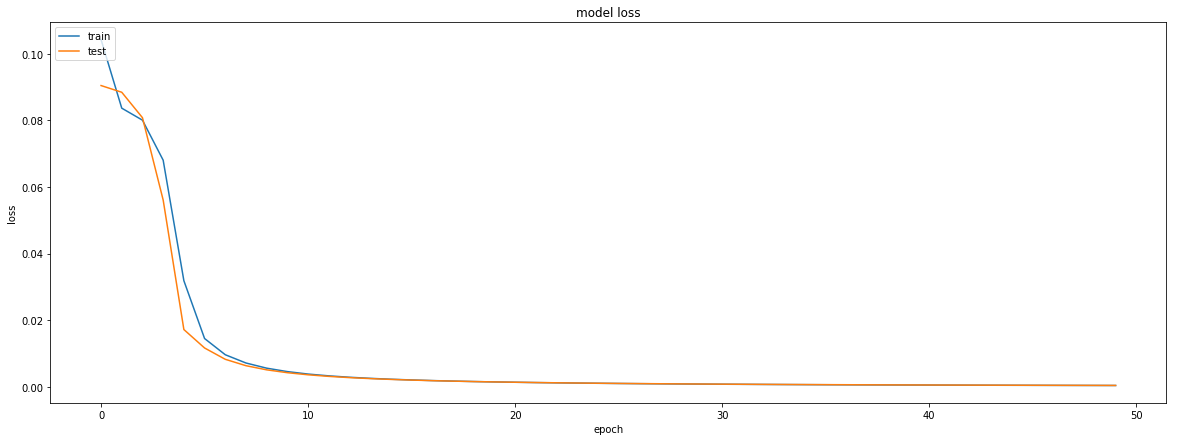

In [48]:
plot_history(history)

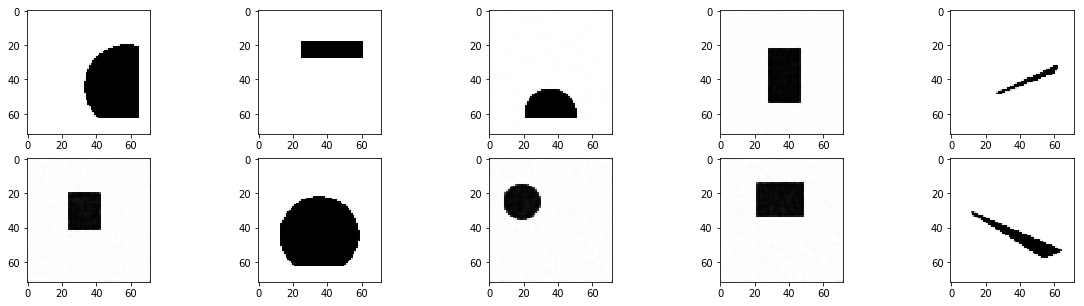

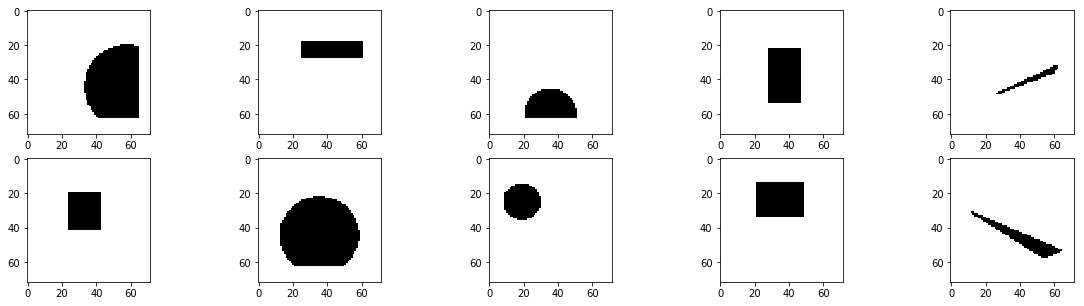

In [49]:
select = 10
fig, ax = plt.subplots(2, 5, figsize=(20, 5))
batch = np.random.choice(len(X_test), select)
for i in range(select):
    selected = X_test[batch[i]]
    selected = selected.reshape(1, selected.shape[0])
    selected = selected.reshape(1,IMAGE_SIZE,IMAGE_SIZE,1)
    ax[i // 5, i % 5].imshow(lol_model.predict(selected)[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
fig, ax = plt.subplots(2, 5, figsize=(20, 5))
for i in range(select):
    ax[i // 5, i % 5].imshow(Y_test[batch[i]].reshape(IMAGE_SIZE, -1), cmap='gray')

The results here are perfect. This shows that understanding the problem leads to better deep learning models.
This model wouldn't work with colored images or if the shapes were not completly black.